## 목표
- 온도와 압력에 의한 패턴 분석 -> 고장 추세 예측
- 불량품 양품 예측

In [2]:
pip install dtw-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mode
import seaborn as sns
from scipy.stats import zscore
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('/disk2/output/input_58.csv')


In [5]:
df.to_csv('./original_data.csv', encoding='CP949')


## 데이터 형태(초기)
- (19429, 17)
- event_time: 제품에 레이저로 코드를 각인한 시각
- result: 양품=0, 불량품=1
- 1_1 : 온도_압력
- *온도(1 or 8), 압력(1 ~ 12)
- 각 행에 '리스트', 결국 str 형태로 총 601개의 값이 존재)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19429 entries, 0 to 19428
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   event_time  19429 non-null  object 
 1   result      19429 non-null  int64  
 2   1_1         12884 non-null  object 
 3   1_2         12883 non-null  object 
 4   1_3         12884 non-null  object 
 5   1_4         0 non-null      float64
 6   1_6         0 non-null      float64
 7   1_7         0 non-null      float64
 8   1_8         11959 non-null  object 
 9   1_9         10970 non-null  object 
 10  1_10        10507 non-null  object 
 11  1_11        0 non-null      float64
 12  1_12        0 non-null      float64
 13  8_1         12848 non-null  object 
 14  8_2         12653 non-null  object 
 15  8_3         12652 non-null  object 
 16  8_4         12848 non-null  object 
dtypes: float64(5), int64(1), object(11)
memory usage: 2.5+ MB


In [7]:
df.shape

(19429, 17)

In [8]:
df.head(5)

,event_time,result,1_1,1_2,1_3,1_4,1_6,1_7,1_8,1_9,1_10,1_11,1_12,8_1,8_2,8_3,8_4
0,2023-04-25 13:44:00,0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,2022-10-07 04:05:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-10-06 02:30:00,0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,2023-05-08 22:12:00,0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,2023-04-28 09:12:00,0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


## 전처리1. Null 제거
#### 열
- 과정 : nan으로 이루어진 열이라고 예상되는 값에 대해서 null값을 세어봄.
- 결과 : 총 5개의 열이 null로만 이루어진 값이기에 drop하여 (19429, 12)로 수정
#### 행
- 과정 : df[:,'1_1':'8_4']에 대해서 null이 10인 경우(event_time, result 제외) 행 drop
- 결과 : 6545개의 행이 null로만 이루어진 값이므로 제거하여 (12884, 12)로 수정

In [9]:
float_col = []
for col in ['1_4', '1_6', '1_7', '1_11', '1_12']:
    total_nan_values = df[col].isnull().sum().sum()
    print (total_nan_values, end = ', ')

19429, 19429, 19429, 19429, 19429, 

In [10]:
df.drop(columns= ['1_4', '1_6', '1_7', '1_11', '1_12'], inplace=True)
df.shape

(19429, 12)

In [11]:
row_index = []
for i in range(0,19429):
    # print(df.loc[i, '1_1':'8_4'])
    total_nan_values = df.loc[i, '1_1':'8_4'].isnull().sum()
    if total_nan_values == 10:
        row_index.append(i)
print(len(row_index))

6545


In [12]:
for num in row_index:
    df.drop(index=num, axis=0, inplace=True)
print(df.shape)

(12884, 12)


In [13]:
# import ast
# import numpy as np

# # Assuming df is your DataFrame containing the data
# data_str = df.loc[7][2]

# # Replace NaN with None
# data_str_cleaned = str(data_str).replace('nan', 'None')

# # Use ast.literal_eval to safely evaluate the cleaned string
# data_list = ast.literal_eval(data_str_cleaned)

# # Convert None back to numpy NaN
# data_array = np.array(data_list)
# data_array[data_array == None] = np.nan

# print(data_array)


## 전처리2. each 데이터(601개)처리
1. str -> list
2. nan -> 0
3. len(data) = 601개로 맞춤 (0으로 채우기)
4. event_time기준으로 index정리

In [14]:
df.columns

Index(['event_time', 'result', '1_1', '1_2', '1_3', '1_8', '1_9', '1_10',
       '8_1', '8_2', '8_3', '8_4'],
      dtype='object')

In [15]:
# str-> list & 0 

def convert_str_to_array(data_str):
    # Handle string representations of lists with 'nan' values
    if isinstance(data_str, str):
        data_list = data_str.replace('[', '').replace(']', '').split(', ')
        data_list = [float(x) if x != 'nan' else np.nan for x in data_list]
        data_array = np.array(data_list)
    else:
        data_array = np.array(data_str)

    # Convert NaN values to 0
    data_array[np.isnan(data_array)] = 0

    return data_array

# Specify the columns you want to apply the conversion to
columns_to_convert = ['1_1', '1_2', '1_3', '1_8', '1_9', '1_10', '8_1', '8_2', '8_3', '8_4']

# Apply the conversion to the specified columns for all rows
for col in columns_to_convert:
    df[col] = df[col].apply(convert_str_to_array)

# Print the updated DataFrame
df.head(2)


,event_time,result,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
0,2023-04-25 13:44:00,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2022-10-06 02:30:00,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [16]:
# # 2. nan -> 0

# # print(data_array_cleaned)
# def nan2zero(convert_data):
#     if isinstance(convert_data, float):  # If it's a single float value
#         return 0 if np.isnan(convert_data) else convert_data
#     else:  # If it's an array
#         data_array_float = convert_data.astype(float)
#         data_array_cleaned = np.nan_to_num(data_array_float, nan=0)
#         return data_array_cleaned
    
# columns_to_convert = ['1_1', '1_2', '1_3', '1_8', '1_9', '1_10', '8_1', '8_2', '8_3', '8_4']

# for col in columns_to_convert:
#     df[col] = df[col].apply(nan2zero)
    
# print('done')

In [17]:
# 3. len(data) = 601개로 맞춤 (0으로 채우기)

list_601 = [0.0] * 601
array_601 = np.array(list_601) 
# print(data_array_cleaned)
def arr_601(convert_data):
    if isinstance(convert_data, float):  # If it's a single float value
        return array_601  # Replace 0 with the predefined list 'list_601'
    else:
        return convert_data
    
columns_to_convert = ['1_1', '1_2', '1_3', '1_8', '1_9', '1_10', '8_1', '8_2', '8_3', '8_4']

for col in columns_to_convert:
    df[col] = df[col].apply(arr_601)
df.head(1)

,event_time,result,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
0,2023-04-25 13:44:00,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [18]:
for time in df['event_time']:
    new_time = pd.to_datetime(time)
    time = new_time
df.shape

(12884, 12)

In [19]:
# 4. event_time기준으로 index정리
df.sort_values(by='event_time', inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.head(1)

(12884, 12)


,event_time,result,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
0,2022-08-10 04:35:00,0,"[700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 0.0...","[366.85, 366.85, 366.85, 366.85, 366.85, 366.8...","[396.6, 396.6, 396.7, 396.7, 396.7, 396.6, 0.0...","[497.425, 495.425, 495.425, 495.425, 495.425, ...","[504.1, 505.8, 505.5, 505.2, 504.8, 504.5, 0.0...","[379.2, 379.1, 378.8, 378.8, 378.6, 378.4, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


#### 최종 drop
- 리스트 요소가 601개가 아닌 경우 존재
- 총 304개로 삭제
- 최종 df.shape = (12850,12)

In [20]:
strange_indices = {}  # 각 열의 이상한 경우의 인덱스를 저장할 딕셔너리 초기화

strange_index = []
for j in range(2, 12):
  # 현재 열의 이상한 경우의 인덱스를 저장할 리스트 초기화
    for i in range(12884):
        ex = df.iloc[i][j]
        len_ex = len(ex)
        if j ==2: 
            if len_ex != 601:
                strange_index.append(i)
        if j != 2:  # 첫 번째 열 이후로는 이전 열의 이상한 인덱스에 현재 열의 이상한 인덱스를 추가
            if len_ex != 601:
                strange_index.append(i)
    # strange_indices[j] = list(set(strange_index))  # 이상한 경우의 인덱스를 딕셔너리에 저장
real_strange_index = list(set(strange_index))
print(real_strange_index)
print(len(real_strange_index))

for num in real_strange_index:
    df.drop(index=num, axis=0, inplace=True)
print(j,'열의 shape = ',df.shape)

[7169, 7170, 8201, 10761, 5646, 12818, 5651, 10772, 10773, 12819, 12820, 4120, 4121, 11801, 11802, 11294, 35, 36, 3110, 3111, 3112, 10282, 7214, 9263, 1584, 1585, 11314, 3123, 3635, 3636, 5686, 11316, 12850, 12347, 10812, 12348, 3653, 8263, 11335, 4173, 4174, 4175, 3152, 3153, 3154, 5712, 11346, 597, 598, 599, 5719, 8278, 11350, 11351, 6237, 6238, 2655, 4710, 8807, 3182, 3183, 3184, 3185, 3697, 11375, 8820, 11376, 12404, 8826, 123, 124, 3198, 1663, 1664, 1665, 1666, 8321, 8322, 6278, 6790, 5624, 5769, 6799, 3216, 10897, 11407, 11408, 5781, 2711, 11424, 11425, 5799, 9895, 8364, 11956, 10423, 8687, 3262, 8688, 5825, 8689, 12486, 12487, 7672, 8690, 7164, 721, 722, 5332, 5333, 7380, 5847, 10457, 8922, 8185, 8415, 9951, 5345, 5346, 5347, 5348, 5349, 1254, 1255, 3815, 3816, 6378, 6379, 8188, 2285, 7405, 8427, 8428, 10472, 9615, 12024, 250, 251, 6910, 2816, 2817, 3845, 775, 776, 777, 9991, 10504, 7482, 12553, 12554, 10000, 1809, 7483, 9489, 9490, 1813, 1814, 1815, 9491, 12567, 10011, 10012, 9

## 데이터 시각화
- 예상 : 불량품과 양품 사이 구분될 만한 특징이 있을 것
- 실제 : 양품사이에서도 각기 다른 추세를 보임 

In [21]:
# import matplotlib.pyplot as plt

# x_time = []
# for i in range(601):
#     x_time.append(i)
# print(len(x_time))

# columns = ['1_1', '1_2', '1_3', '1_8', '1_9', '1_10', '8_1', '8_2', '8_3', '8_4']
# plt.figure(figsize=(60,20))

# plt.subplot(2, 2, 1)
# for i in range(0,10) :
#     y = df.loc[0][columns[i]]
#     plt.plot(x_time, y, '-', label=columns[i]) 
# plt.title('1st')
# plt.legend()


# # plt.figure(figsize=(15, 5))
# plt.subplot(2, 2, 2)
# for i in range(0,10) :
#     y = df.loc[1][columns[i]]
#     plt.plot(x_time, y, '-', label=columns[i])
# plt.title('2st')
# plt.legend()

# # plt.figure(figsize=(15, 5))
# plt.subplot(2, 2, 3)
# for i in range(0,10) :
#     y = df.loc[12872][columns[i]]
#     plt.plot(x_time, y, '-', label=columns[i])
# plt.title('defective')
# plt.legend()


# # plt.figure(figsize=(15, 5))
# plt.subplot(2, 2, 4)
# for i in range(0,10) :
#     y = df.loc[12838][columns[i]]
#     plt.plot(x_time, y, '-', label=columns[i])
# plt.title('defective')
# plt.legend()


## 데이터 전처리의 문제점
- 불량품과 양품 사이 구별할만한 뚜렷한 추세가 보이지 않음
- 최대최소 정규화(논문) 적용 불가능 -> 대신 정규화라도 해야하나

## 불균형 데이터
- 대락 5:1정도 

Index([0, 1], dtype='int64', name='result') [10250  2330]


<BarContainer object of 2 artists>

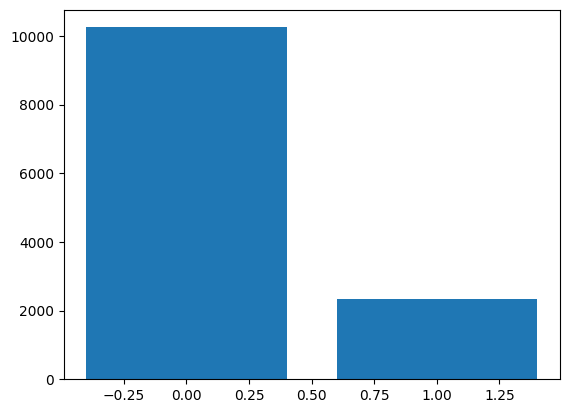

In [22]:
y_cla = df['result'].value_counts()
y_cla_ind = y_cla.index
y_cla_val = y_cla.values
print(y_cla_ind, y_cla_val)

plt.bar(y_cla_ind, y_cla_val)

# 최종데이터

In [23]:
df.head(1)

,event_time,result,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
0,2022-08-10 04:35:00,0,"[700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 0.0...","[366.85, 366.85, 366.85, 366.85, 366.85, 366.8...","[396.6, 396.6, 396.7, 396.7, 396.7, 396.6, 0.0...","[497.425, 495.425, 495.425, 495.425, 495.425, ...","[504.1, 505.8, 505.5, 505.2, 504.8, 504.5, 0.0...","[379.2, 379.1, 378.8, 378.8, 378.6, 378.4, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# df -> data

In [24]:
import copy
data = df.copy(deep=True)

In [25]:
# data.to_csv('./copied_data.csv', sep=',')

In [26]:
data.head()

,event_time,result,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
0,2022-08-10 04:35:00,0,"[700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 0.0...","[366.85, 366.85, 366.85, 366.85, 366.85, 366.8...","[396.6, 396.6, 396.7, 396.7, 396.7, 396.6, 0.0...","[497.425, 495.425, 495.425, 495.425, 495.425, ...","[504.1, 505.8, 505.5, 505.2, 504.8, 504.5, 0.0...","[379.2, 379.1, 378.8, 378.8, 378.6, 378.4, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2022-08-19 15:45:00,0,"[696.0, 0.0, 696.0, 696.0, 696.0, 696.0, 696.0...","[361.55, 0.0, 361.55, 361.55, 361.6, 361.6, 36...","[381.5, 0.0, 381.5, 381.4, 381.4, 381.3, 381.3...","[419.425, 0.0, 419.425, 419.425, 419.425, 419....","[495.1, 0.0, 495.1, 495.0, 495.0, 495.0, 495.0...","[365.5, 0.0, 365.1, 364.8, 364.6, 364.3, 364.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2022-08-22 01:09:00,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2022-08-22 01:25:00,0,"[700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 700...","[362.05, 362.05, 362.05, 362.05, 362.05, 362.0...","[408.2, 408.2, 408.2, 408.2, 408.2, 408.2, 408...","[52.928, 52.928, 52.928, 53.178, 53.178, 53.42...","[516.8, 516.8, 518.4, 517.6, 519.2, 518.4, 517...","[392.45, 392.45, 392.3, 392.3, 392.2, 392.15, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,2022-08-22 01:44:00,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [27]:
data.shape

(12580, 12)

In [28]:
time = data['event_time']
result = data['result']

In [29]:
time.head()

0    2022-08-10 04:35:00
1    2022-08-19 15:45:00
2    2022-08-22 01:09:00
3    2022-08-22 01:25:00
4    2022-08-22 01:44:00
Name: event_time, dtype: object

In [30]:
result.head()

0    0
1    0
2    0
3    0
4    0
Name: result, dtype: int64

In [31]:
data.drop(columns = ['event_time'], inplace = True)
data.head(1)

,result,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
0,0,"[700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 0.0...","[366.85, 366.85, 366.85, 366.85, 366.85, 366.8...","[396.6, 396.6, 396.7, 396.7, 396.7, 396.6, 0.0...","[497.425, 495.425, 495.425, 495.425, 495.425, ...","[504.1, 505.8, 505.5, 505.2, 504.8, 504.5, 0.0...","[379.2, 379.1, 378.8, 378.8, 378.6, 378.4, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [32]:
y = data['result']
X = data.drop(['result'], axis = 1)
X.tail(1)

,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
12883,"[696.0, 696.0, 696.0, 696.0, 696.0, 696.0, 696...","[360.7, 360.7, 360.7, 360.7, 360.7, 360.7, 360...","[377.3, 377.3, 377.3, 377.3, 377.3, 377.3, 377...","[493.425, 495.425, 497.425, 497.425, 499.425, ...","[489.9, 491.4, 490.2, 493.4, 492.1, 493.2, 494...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[819.0, 818.0, 818.0, 821.0, 808.0, 820.0, 807...","[819.0, 819.0, 819.0, 819.0, 819.0, 819.0, 819...","[822.0, 822.0, 822.0, 822.0, 822.0, 822.0, 822...","[3.0, 4.0, 4.0, 1.0, 8.0, 2.0, 9.0, 1.0, 16.0,..."


In [33]:
# dataset -> 3D
def temporalize(XX):
    X = []
    # scaler = MinMaxScaler()
    for i in range(XX.shape[0]):
        end = []
        for j in range(0, 601):
            st = []
            for t in range(0, 10):
                zero = XX[i,t][j]
                st.append(zero)
            end.append(st)
        X.append(end)
    
    X = np.array(X)
    
    return X
X_3D = temporalize(X.values)

print("X_3D: ", X_3D.shape)

subset = X_3D[:5, :, :]
print(subset)

X_3D:  (12580, 601, 10)
[[[700.   366.85 396.6  ...   0.     0.     0.  ]
  [700.   366.85 396.6  ...   0.     0.     0.  ]
  [700.   366.85 396.7  ...   0.     0.     0.  ]
  ...
  [  0.     0.     0.   ...   0.     0.     0.  ]
  [  0.     0.     0.   ...   0.     0.     0.  ]
  [  0.     0.     0.   ...   0.     0.     0.  ]]

 [[696.   361.55 381.5  ...   0.     0.     0.  ]
  [  0.     0.     0.   ...   0.     0.     0.  ]
  [696.   361.55 381.5  ...   0.     0.     0.  ]
  ...
  [700.   362.05 373.6  ... 852.   825.    36.  ]
  [700.   362.05 373.5  ... 852.   825.    34.  ]
  [  0.     0.     0.   ...   0.     0.     0.  ]]

 [[  0.     0.     0.   ...   0.     0.     0.  ]
  [  0.     0.     0.   ...   0.     0.     0.  ]
  [  0.     0.     0.   ...   0.     0.     0.  ]
  ...
  [696.   363.65 417.6  ...   0.     0.     1.  ]
  [696.   363.65 417.6  ...   0.     0.     1.  ]
  [696.   363.65 417.7  ...   0.     0.     1.  ]]

 [[700.   362.05 408.2  ...   0.     0.     1.  ]
  

In [34]:
print("X_3D: ", X_3D.shape)
print("y: ", y.shape)

X_3D:  (12580, 601, 10)
y:  (12580,)


# (12580*601)의 사이즈를 가진 10개의 데이터프레임으로 나누기

In [35]:
data_list = np.dsplit(X_3D, 10)
data_list = [np.squeeze(data, axis=2) for data in data_list]

In [36]:
data_list[0]

array([[700., 700., 700., ...,   0.,   0.,   0.],
       [696.,   0., 696., ..., 700., 700.,   0.],
       [  0.,   0.,   0., ..., 696., 696., 696.],
       ...,
       [692., 692., 692., ..., 692., 692., 692.],
       [696., 696., 696., ...,   0.,   0.,   0.],
       [696., 696., 696., ...,   0.,   0.,   0.]])

In [37]:
data_frames = [pd.DataFrame(data, columns=[i for i in range(data.shape[1])]) for data in data_list]

# Rename the DataFrames to data1, data2, ..., data10
for i, df in enumerate(data_frames, start=1):
    globals()[f'data{i}'] = df

In [38]:
newdata_list= [data1, data2, data3, data4, data5, data6, data7, data8, data9, data10]

In [39]:
data1.tail()

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,600
12575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,692.0,692.0,692.0,692.0,692.0,692.0,692.0,692.0,692.0,692.0
12576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,692.0,692.0,692.0,692.0,692.0,692.0,692.0,692.0,692.0,692.0
12577,692.0,692.0,692.0,692.0,692.0,692.0,692.0,692.0,692.0,692.0,...,692.0,692.0,692.0,0.0,692.0,692.0,692.0,692.0,692.0,692.0
12578,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12579,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
print(time.shape)
print(result.shape)
print(data1.shape)

(12580,)
(12580,)
(12580, 601)


In [41]:
result = result.reset_index(drop=True)
time = time.reset_index(drop=True)

In [42]:
time.tail()

12575    2023-07-04 16:18:00
12576    2023-07-04 16:23:00
12577    2023-07-04 16:28:00
12578    2023-07-04 18:02:00
12579    2023-07-04 21:48:00
Name: event_time, dtype: object

In [43]:
data1 = pd.concat([data1, result, time], axis=1, ignore_index=False)
data2 = pd.concat([data2, result, time], axis=1, ignore_index=False)
data3 = pd.concat([data3, result, time], axis=1, ignore_index=False)
data4 = pd.concat([data4, result, time], axis=1, ignore_index=False)
data5 = pd.concat([data5, result, time], axis=1, ignore_index=False)
data6 = pd.concat([data6, result, time], axis=1, ignore_index=False)
data7 = pd.concat([data7, result, time], axis=1, ignore_index=False)
data8 = pd.concat([data8, result, time], axis=1, ignore_index=False)
data9 = pd.concat([data9, result, time], axis=1, ignore_index=False)
data10 = pd.concat([data10, result, time], axis=1, ignore_index=False)

In [44]:
data1.head()

,0,1,2,3,4,5,6,7,8,9,...,593,594,595,596,597,598,599,600,result,event_time
0,700.0,700.0,700.0,700.0,700.0,700.0,0.0,700.0,700.0,700.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2022-08-10 04:35:00
1,696.0,0.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,...,700.0,700.0,700.0,700.0,700.0,700.0,700.0,0.0,0,2022-08-19 15:45:00
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,0,2022-08-22 01:09:00
3,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2022-08-22 01:25:00
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,0,2022-08-22 01:44:00


In [45]:
newdata_list= [data1, data2, data3, data4, data5, data6, data7, data8, data9, data10]

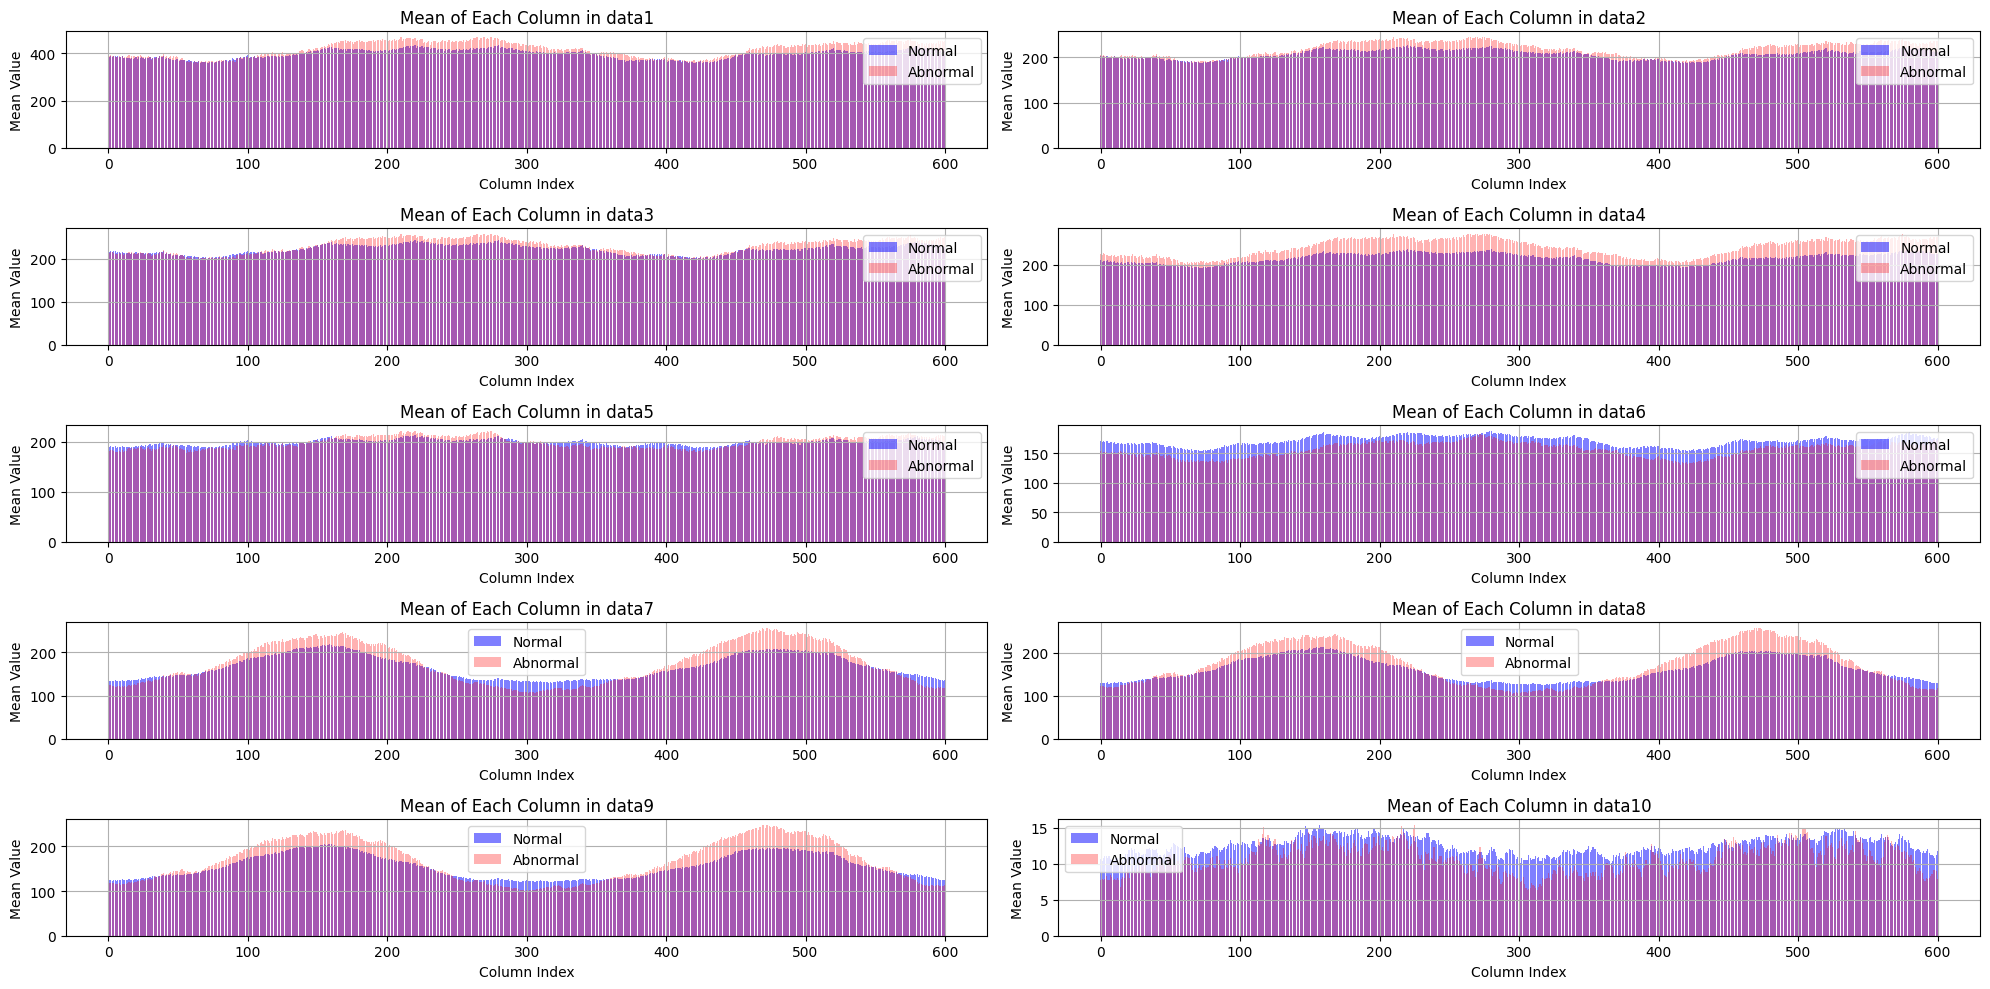

In [46]:
plt.figure(figsize=(20, 10))

for i, df in enumerate(newdata_list):
    plt.subplot(5, 2, i+1)
    
    # 'event_time'과 'result' 열을 제외하고 각 열의 평균 계산
    df_result_0 = df[df['result'] == 0].drop(['result', 'event_time'], axis=1)
    df_result_1 = df[df['result'] == 1].drop(['result', 'event_time'], axis=1)
    
    column_means_result_0 = df_result_0.mean()
    column_means_result_1 = df_result_1.mean()
    
    # 평균 값을 막대 그래프로 표현
    plt.bar(column_means_result_0.index, column_means_result_0, color='b', label='Normal', alpha=0.5)
    plt.bar(column_means_result_1.index, column_means_result_1, color='r', label='Abnormal', alpha=0.3)
    
    plt.title(f'Mean of Each Column in data{i + 1}')
    plt.xlabel('Column Index')
    plt.ylabel('Mean Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

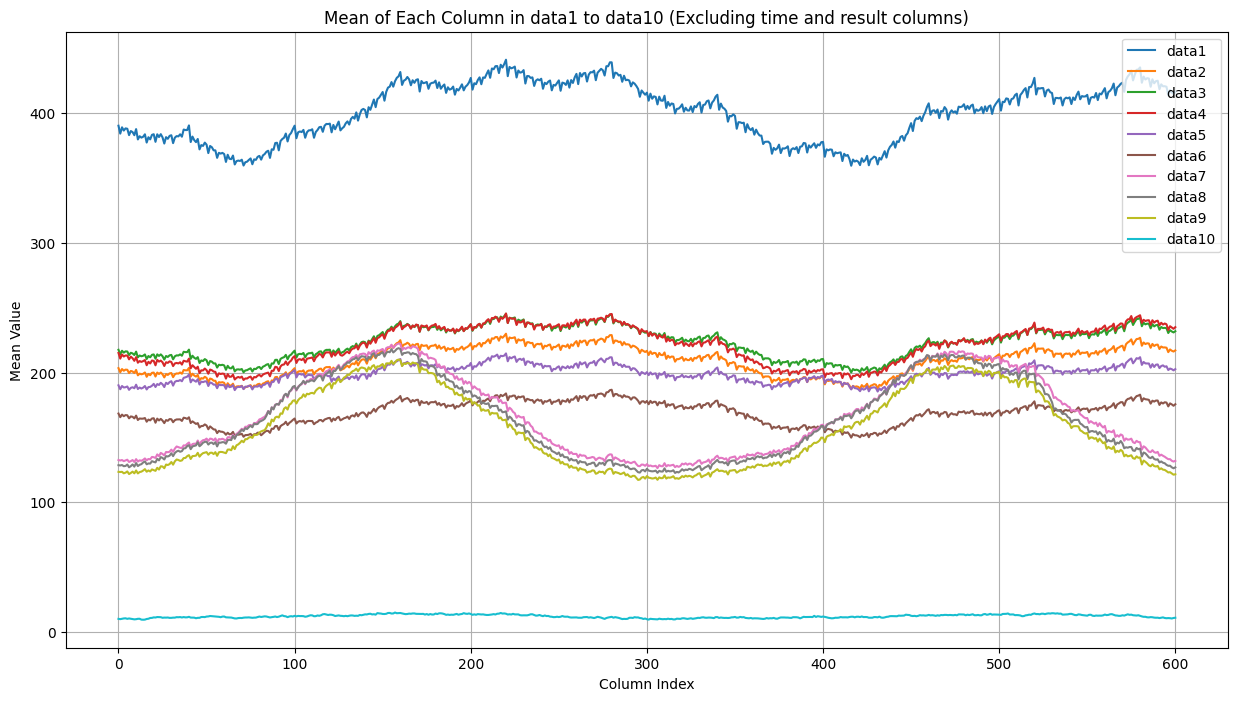

In [47]:
plt.figure(figsize=(15, 8))

for i, df in enumerate(newdata_list):
    # 'event_time'과 'result' 열을 제외하고 각 열의 평균 계산
    column_means_excluded = df.drop(['event_time', 'result'], axis=1).mean()
    
    # 시각화
    plt.plot(column_means_excluded, label=f'data{i + 1}')

plt.title('Mean of Each Column in data1 to data10 (Excluding time and result columns)')
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.legend()
plt.grid(True)
plt.show()

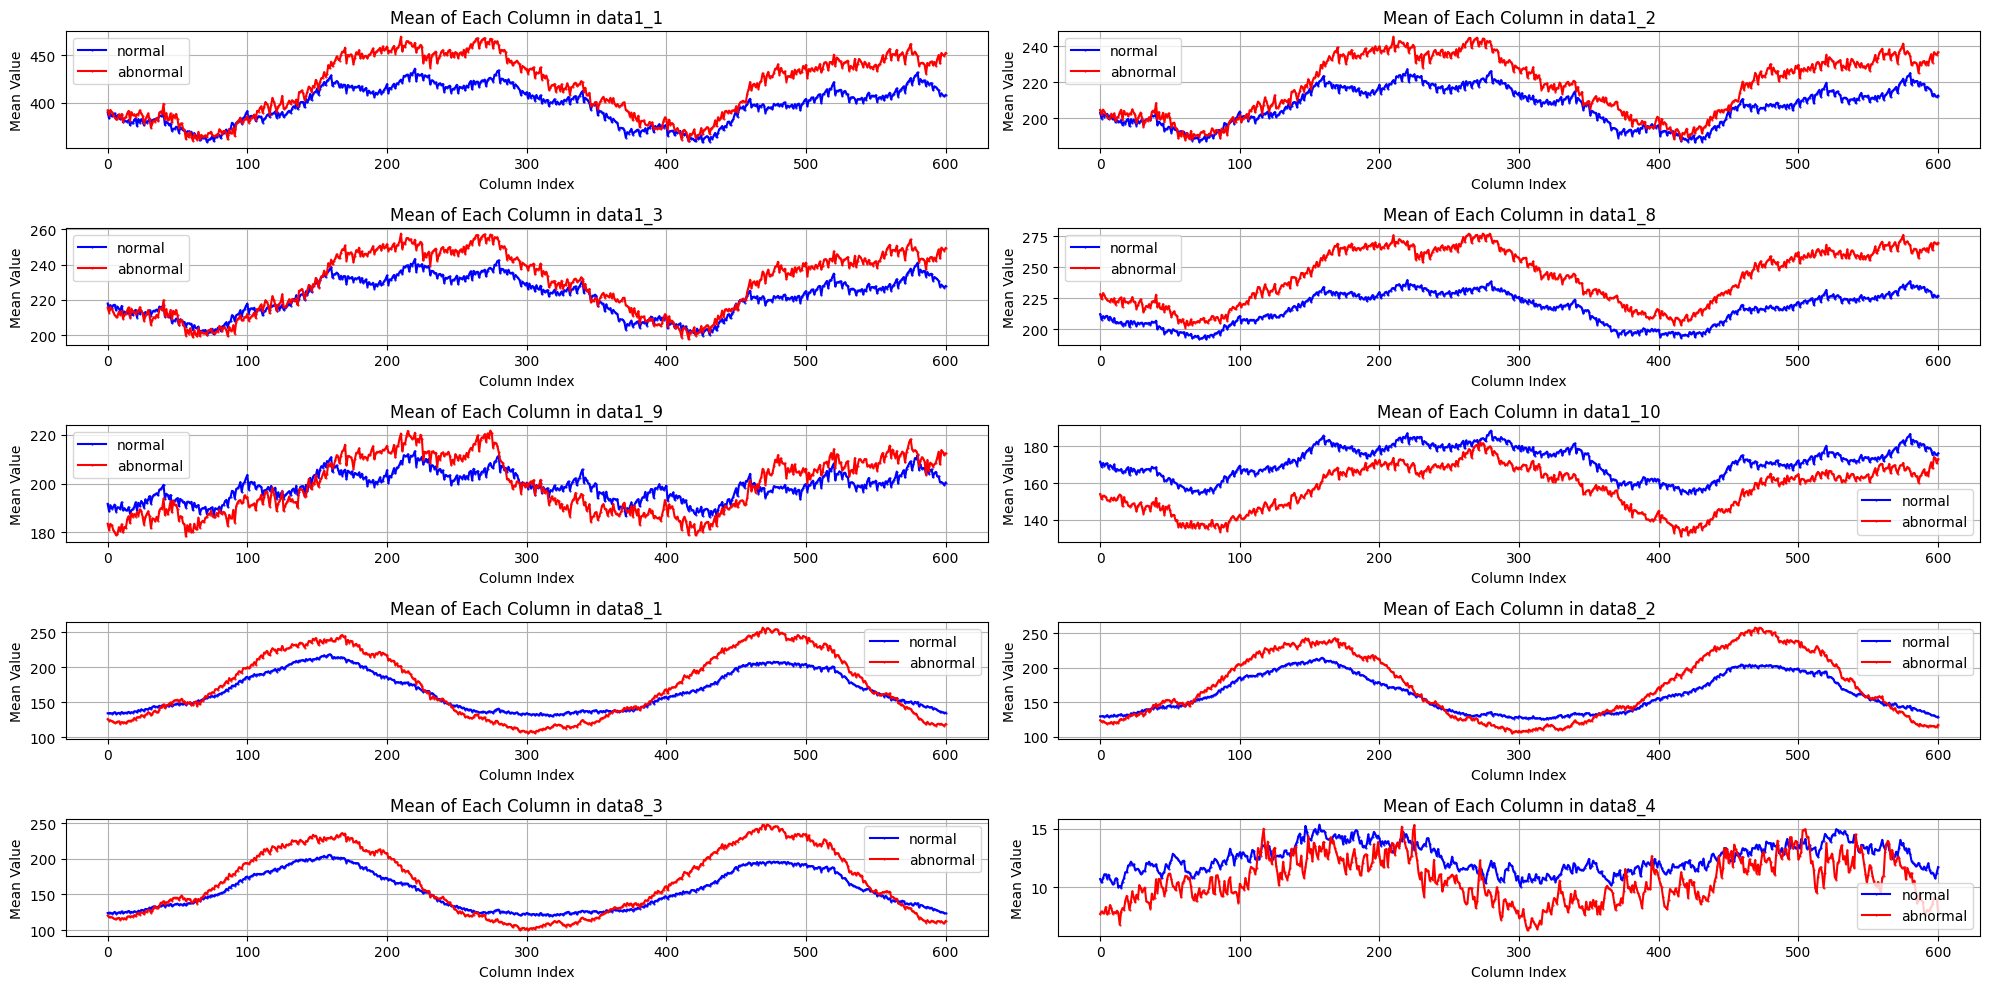

In [48]:
plt.figure(figsize=(20, 10))
columns_to_convert = ['1_1', '1_2', '1_3', '1_8', '1_9', '1_10', '8_1', '8_2', '8_3', '8_4']
for i, df in enumerate(newdata_list):
    # 'event_time'과 'result' 열을 제외하고 각 열의 평균 계산
    df_result_0 = df[df['result'] == 0].drop(['result', 'event_time'], axis=1)
    df_result_1 = df[df['result'] == 1].drop(['result', 'event_time'], axis=1)
    
    column_means_result_0 = df_result_0.mean()
    column_means_result_1 = df_result_1.mean()
    
    # 시각화
    plt.subplot(5, 2, i+1)
    plt.plot(column_means_result_0, marker='o', linestyle='-', color='b', markersize=0.5, label='normal') 
    plt.plot(column_means_result_1, marker='o', linestyle='-', color='r', markersize=0.5, label='abnormal') 
    plt.title(f'Mean of Each Column in data{columns_to_convert[i]}')
    plt.xlabel('Column Index')
    plt.ylabel('Mean Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [50]:
scaler = MinMaxScaler()

# data_reg1부터 data_reg10까지의 데이터프레임을 저장할 리스트 초기화
data_reg_list = []

# 각 데이터프레임을 정규화하고 결과를 data_reg_list에 저장
for i, df in enumerate(newdata_list):
    # 'event_time'과 'result' 열을 제외하고 각 열을 정규화
    df_no_event_result = df.drop(['event_time', 'result'], axis=1)
    df_normalized = pd.DataFrame(scaler.fit_transform(df_no_event_result), columns=df_no_event_result.columns)
    
    # 정규화된 데이터프레임에 'event_time'과 'result' 열 추가
    df_normalized['event_time'] = df['event_time']
    df_normalized['result'] = df['result']
    
    # 결과를 리스트에 추가
    data_reg_list.append(df_normalized)

# 결과 확인
for i, df_reg in enumerate(data_reg_list):
    print(f"data_reg{i + 1} shape: {df_reg.shape}")

data_reg1 shape: (12580, 603)
data_reg2 shape: (12580, 603)
data_reg3 shape: (12580, 603)
data_reg4 shape: (12580, 603)
data_reg5 shape: (12580, 603)
data_reg6 shape: (12580, 603)
data_reg7 shape: (12580, 603)
data_reg8 shape: (12580, 603)
data_reg9 shape: (12580, 603)
data_reg10 shape: (12580, 603)


In [51]:
for i in range(len(data_reg_list)):
    globals()[f"data_reg{i + 1}"] = data_reg_list[i]

In [52]:
data_reg_list = [data_reg1, data_reg2, data_reg3, data_reg4, data_reg5, data_reg6, data_reg7, data_reg8, data_reg9, data_reg10]

In [53]:
data_reg1.tail()

,0,1,2,3,4,5,6,7,8,9,...,593,594,595,596,597,598,599,600,event_time,result
12575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.935135,0.961111,0.961111,0.915344,0.961111,0.955801,0.955801,0.955801,2023-07-04 16:18:00,0
12576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.935135,0.961111,0.961111,0.915344,0.961111,0.955801,0.955801,0.955801,2023-07-04 16:23:00,0
12577,0.955801,0.955801,0.955801,0.955801,0.955801,0.955801,0.955801,0.955801,0.955801,0.955801,...,0.935135,0.000000,0.961111,0.915344,0.961111,0.955801,0.955801,0.955801,2023-07-04 16:28:00,0
12578,0.961326,0.961326,0.961326,0.961326,0.961326,0.961326,0.961326,0.961326,0.961326,0.961326,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2023-07-04 18:02:00,0
12579,0.961326,0.961326,0.961326,0.961326,0.961326,0.961326,0.961326,0.961326,0.961326,0.961326,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2023-07-04 21:48:00,0


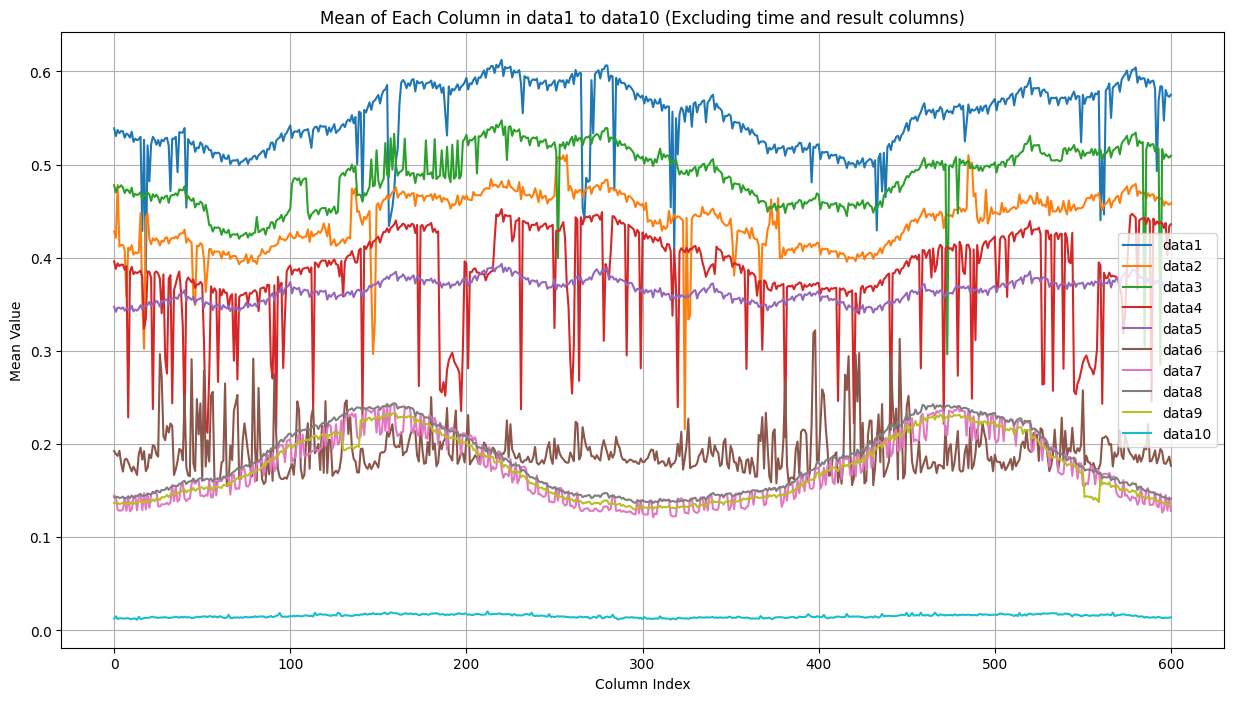

In [54]:
plt.figure(figsize=(15, 8))

for i, df in enumerate(data_reg_list):
    # 'event_time'과 'result' 열을 제외하고 각 열의 평균 계산
    column_means_excluded = df.drop(['event_time', 'result'], axis=1).mean()
    
    # 시각화
    plt.plot(column_means_excluded, label=f'data{i + 1}')

plt.title('Mean of Each Column in data1 to data10 (Excluding time and result columns)')
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.legend()
plt.grid(True)
plt.show()

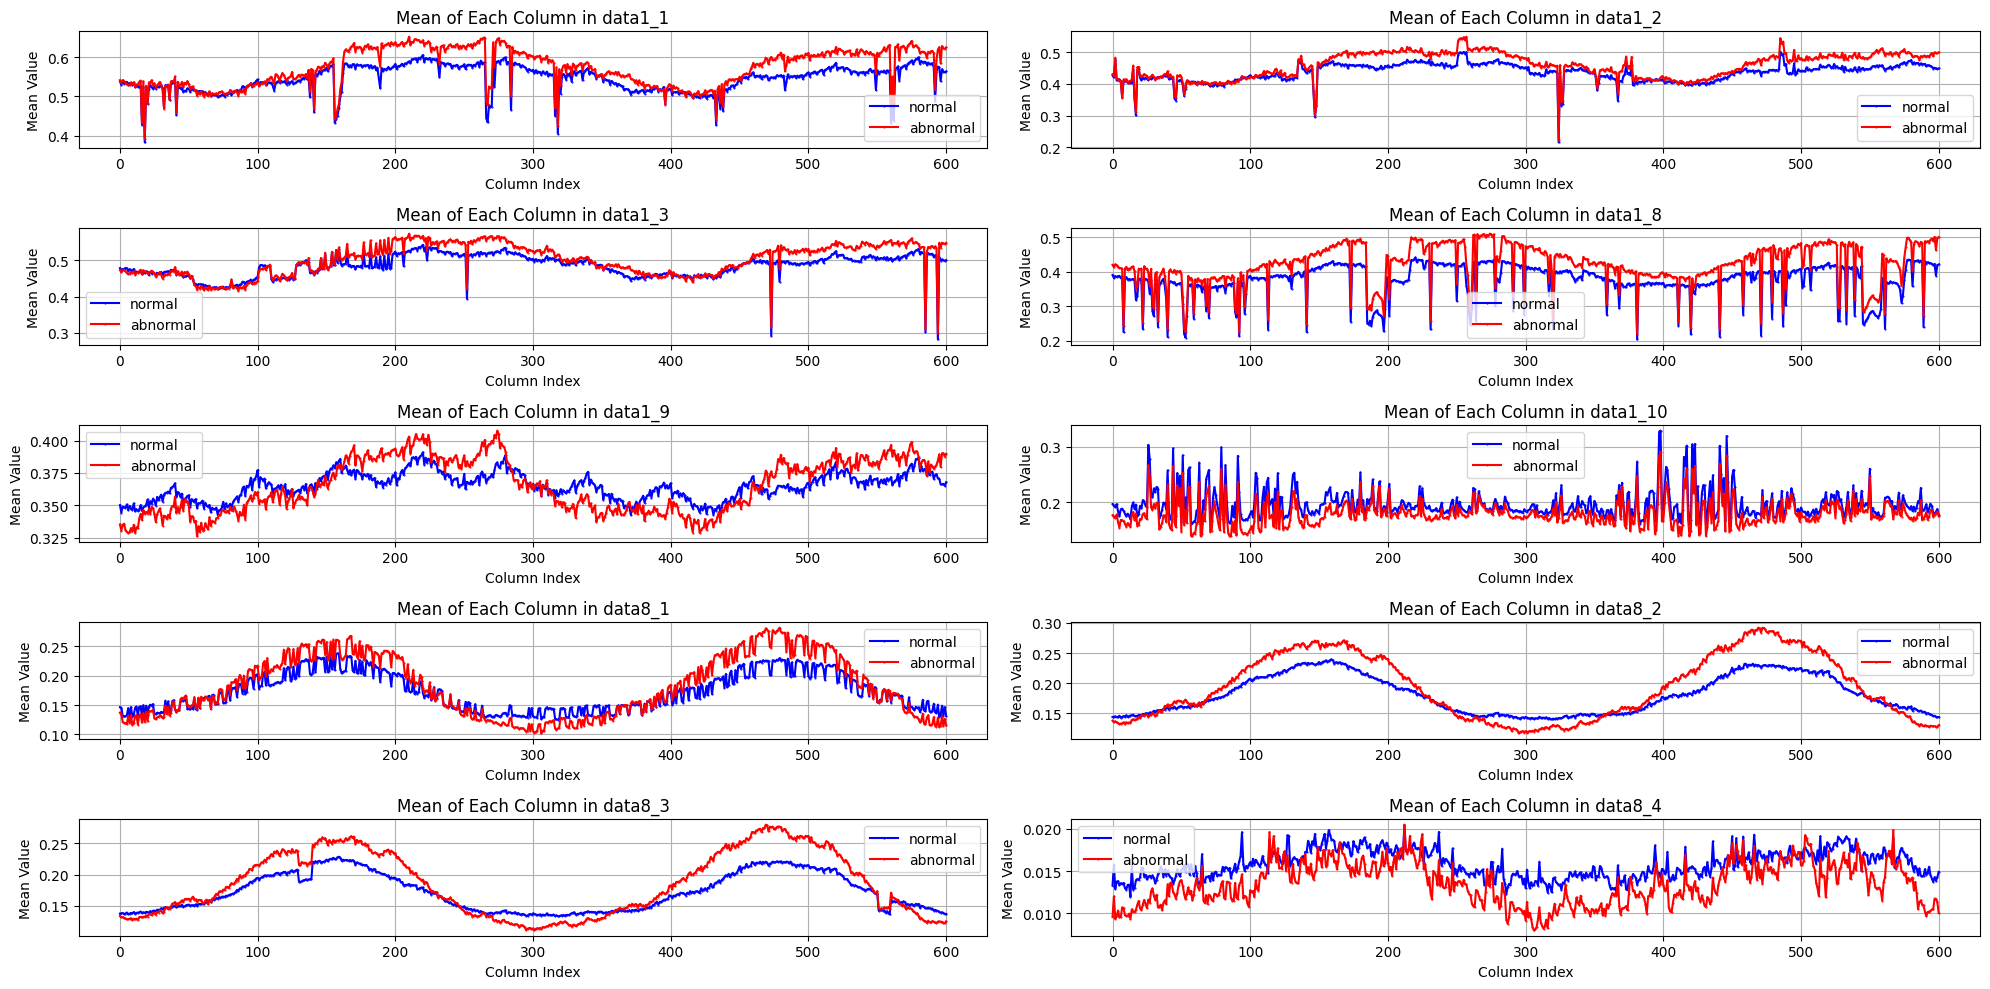

In [52]:
plt.figure(figsize=(20,10))

for i, df in enumerate(data_reg_list):
    # 'event_time'과 'result' 열을 제외하고 각 열의 평균 계산
    df_result_0 = df[df['result'] == 0].drop(['result', 'event_time'], axis=1)
    df_result_1 = df[df['result'] == 1].drop(['result', 'event_time'], axis=1)
    
    column_means_result_0 = df_result_0.mean()
    column_means_result_1 = df_result_1.mean()
    
    # 시각화
    plt.subplot(5, 2, i+1)
    plt.plot(column_means_result_0, marker='o', linestyle='-', color='b', markersize=0.5, label='normal') 
    plt.plot(column_means_result_1, marker='o', linestyle='-', color='r', markersize=0.5, label='abnormal') 
    plt.title(f'Mean of Each Column in data{columns_to_convert[i]}')
    plt.xlabel('Column Index')
    plt.ylabel('Mean Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [56]:
data1.tail()

,0,1,2,3,4,5,6,7,8,9,...,593,594,595,596,597,598,599,600,result,event_time
12575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,692.0,692.0,692.0,692.0,692.0,692.0,692.0,692.0,0,2023-07-04 16:18:00
12576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,692.0,692.0,692.0,692.0,692.0,692.0,692.0,692.0,0,2023-07-04 16:23:00
12577,692.0,692.0,692.0,692.0,692.0,692.0,692.0,692.0,692.0,692.0,...,692.0,0.0,692.0,692.0,692.0,692.0,692.0,692.0,0,2023-07-04 16:28:00
12578,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-07-04 18:02:00
12579,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2023-07-04 21:48:00


In [57]:
# RobustScaler 인스턴스 생성
scaler = RobustScaler()

# data_reg1부터 data_reg10까지의 데이터프레임을 저장할 리스트 초기화
data_z_list = []

# 각 데이터프레임을 정규화하고 결과를 data_reg_list에 저장
for i, df in enumerate(newdata_list):
    # 'event_time'과 'result' 열을 제외하고 각 열을 정규화
    df_no_event_result = df.drop(['event_time', 'result'], axis=1)
    df_normalized = pd.DataFrame(scaler.fit_transform(df_no_event_result), columns=df_no_event_result.columns)
    
    # 정규화된 데이터프레임에 'event_time'과 'result' 열 추가
    df_normalized['event_time'] = df['event_time']
    df_normalized['result'] = df['result']
    
    # 결과를 리스트에 추가
    data_z_list.append(df_normalized)

# 결과 확인
for i, df_z in enumerate(data_z_list):
    print(f"data_z_{i + 1} shape: {df_z.shape}")

data_z_1 shape: (12580, 603)
data_z_2 shape: (12580, 603)
data_z_3 shape: (12580, 603)
data_z_4 shape: (12580, 603)
data_z_5 shape: (12580, 603)
data_z_6 shape: (12580, 603)
data_z_7 shape: (12580, 603)
data_z_8 shape: (12580, 603)
data_z_9 shape: (12580, 603)
data_z_10 shape: (12580, 603)


In [58]:
for i in range(len(data_z_list)):
    globals()[f"data_z_{i + 1}"] = data_z_list[i]

In [59]:
data_z_1, data_z_2, data_z_3, data_z_4, data_z_5, data_z_6, data_z_7, data_z_8, data_z_9, data_z_10 = data_z_list

In [60]:
data_z_10

,0,1,2,3,4,5,6,7,8,9,...,593,594,595,596,597,598,599,600,event_time,result
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2022-08-10 04:35:00,0
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,4.375,4.375,4.250,4.375,4.250,4.500,4.250,0.000,2022-08-19 15:45:00,0
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,2022-08-22 01:09:00,0
3,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2022-08-22 01:25:00,0
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,2022-08-22 01:44:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12575,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2023-07-04 16:18:00,0
12576,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2023-07-04 16:23:00,0
12577,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2023-07-04 16:28:00,0
12578,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2023-07-04 18:02:00,0


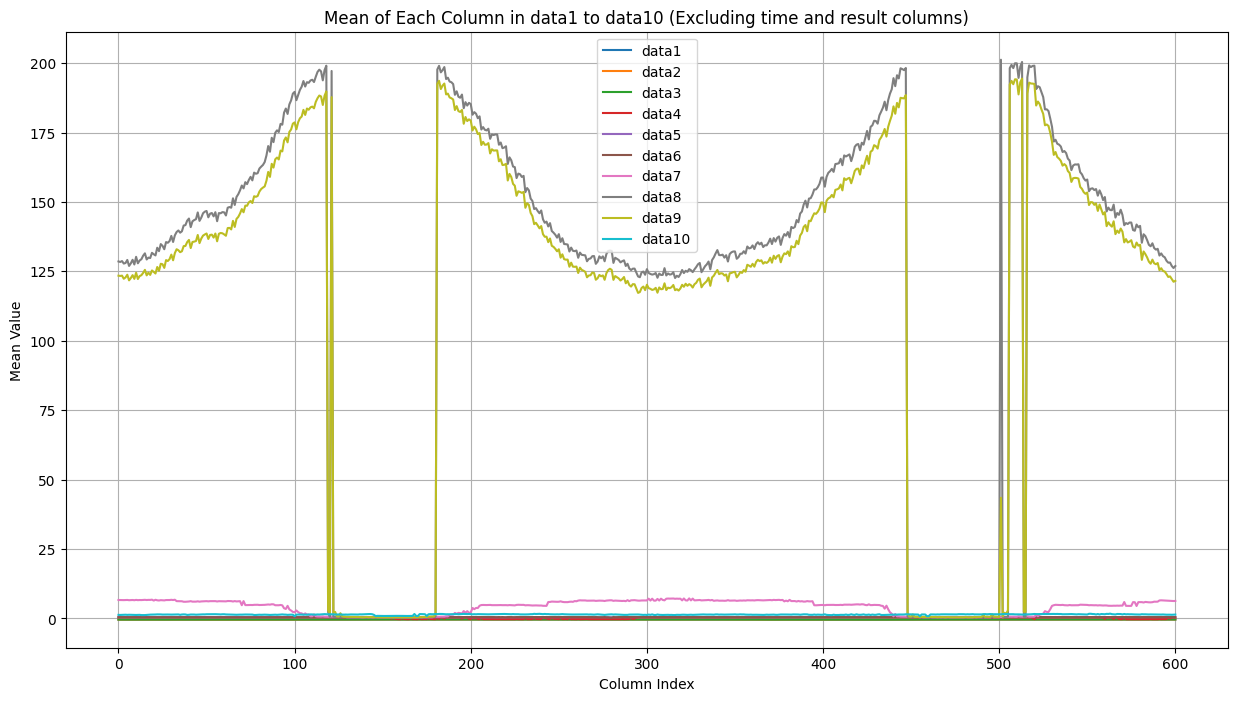

In [91]:
plt.figure(figsize=(15, 8))

for i, df in enumerate(data_z_list):
    # 'event_time'과 'result' 열을 제외하고 각 열의 평균 계산
    column_means_excluded = df.drop(['event_time', 'result'], axis=1).mean()
    
    # 시각화
    plt.plot(column_means_excluded, label=f'data{i + 1}')

plt.title('Mean of Each Column in data1 to data10 (Excluding time and result columns)')
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.legend()
plt.grid(True)
plt.show()

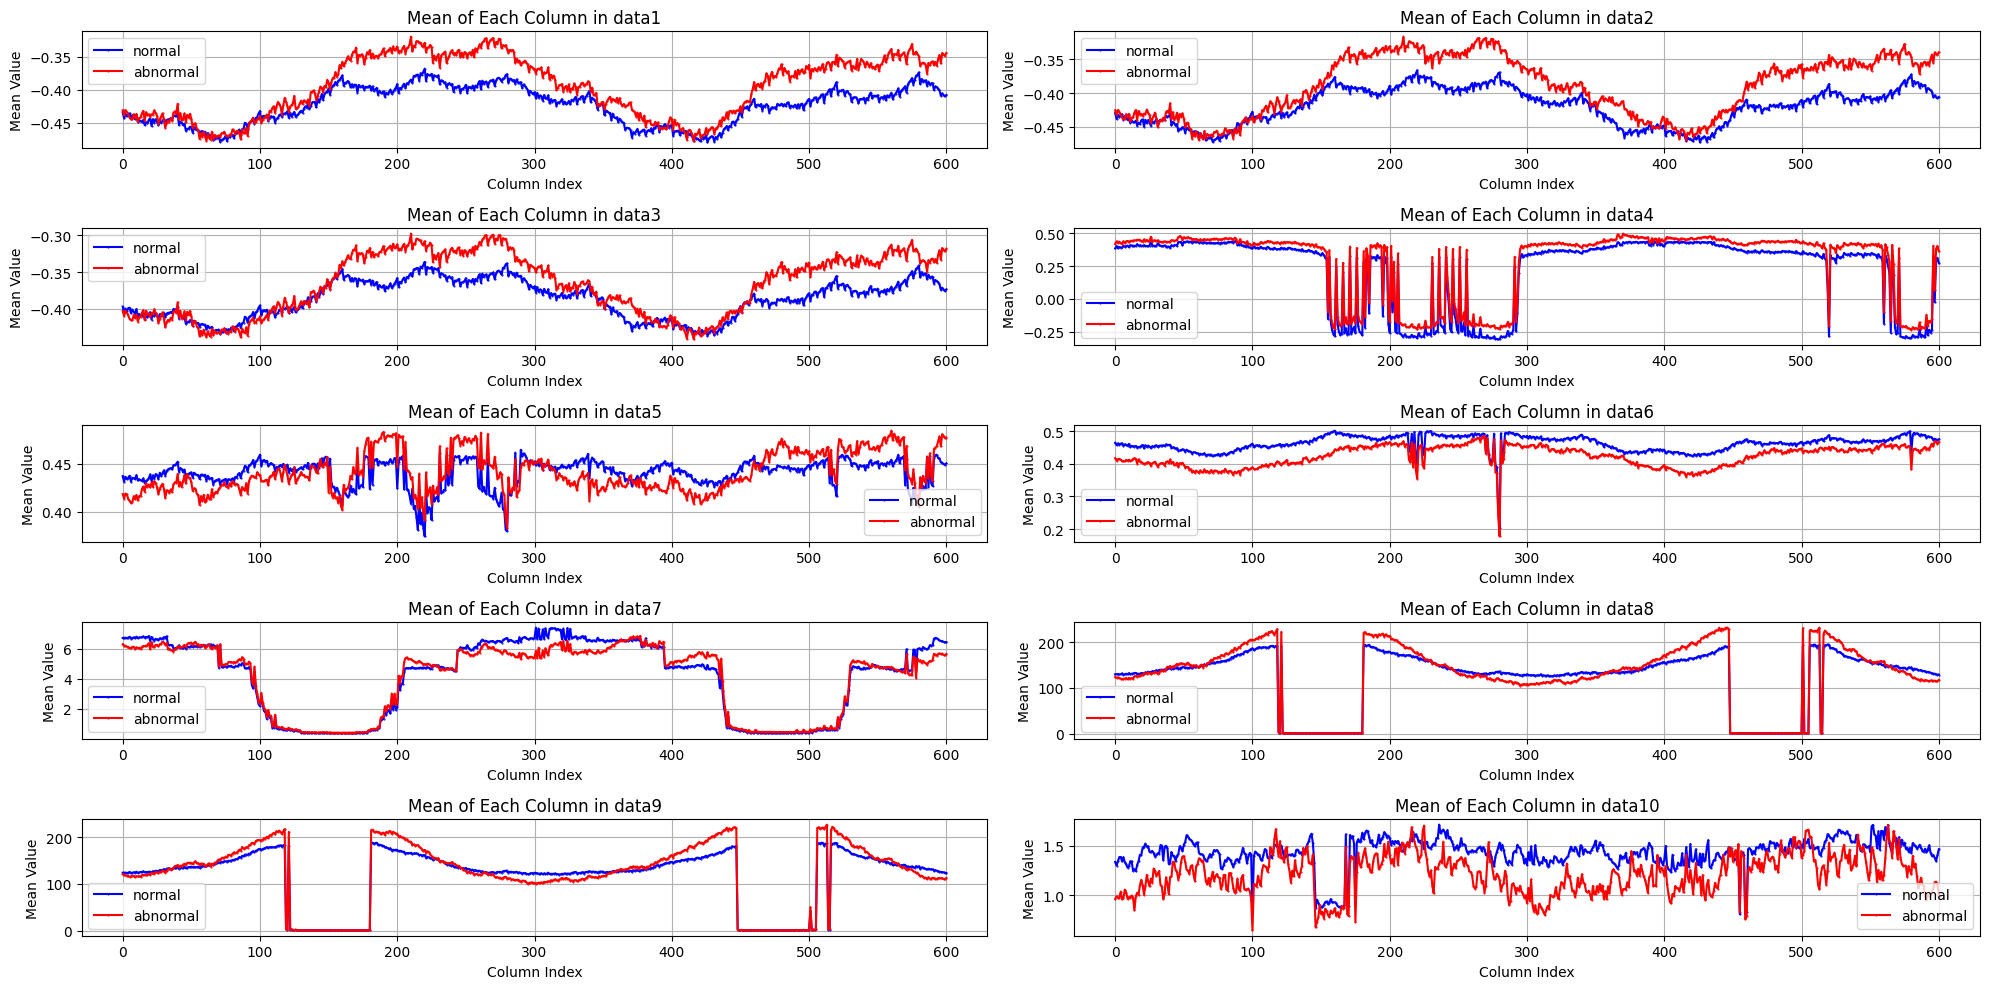

In [62]:
plt.figure(figsize=(20,10))

for i, df in enumerate(data_z_list):
    # 'event_time'과 'result' 열을 제외하고 각 열의 평균 계산
    df_result_0 = df[df['result'] == 0].drop(['result', 'event_time'], axis=1)
    df_result_1 = df[df['result'] == 1].drop(['result', 'event_time'], axis=1)
    
    column_means_result_0 = df_result_0.mean()
    column_means_result_1 = df_result_1.mean()
    
    # 시각화
    plt.subplot(5, 2, i+1)
    plt.plot(column_means_result_0, marker='o', linestyle='-', color='b', markersize=0.5, label='normal') 
    plt.plot(column_means_result_1, marker='o', linestyle='-', color='r', markersize=0.5, label='abnormal') 
    plt.title(f'Mean of Each Column in data{columns_to_convert[i]}')
    plt.xlabel('Column Index')
    plt.ylabel('Mean Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

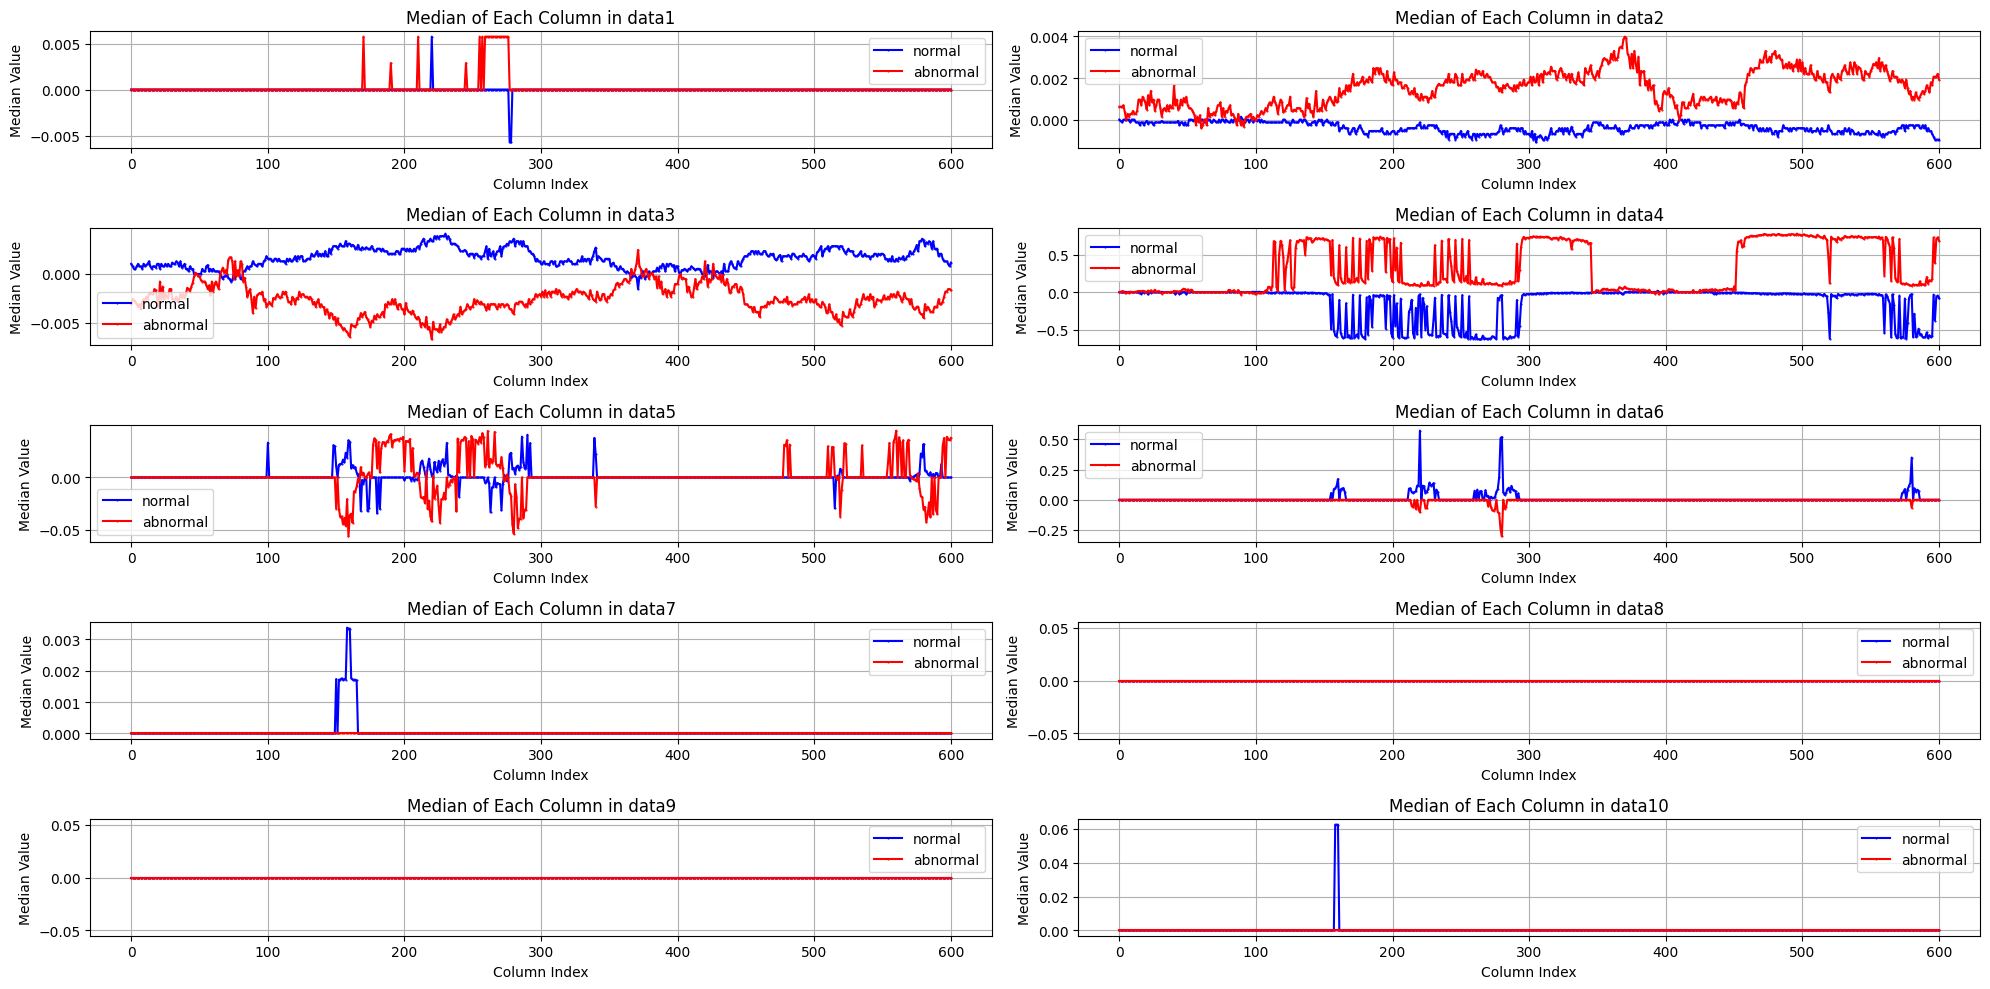

In [63]:
plt.figure(figsize=(20, 10))

for i, df in enumerate(data_z_list):
    # 'event_time'과 'result' 열을 제외하고 각 열의 중앙값 계산
    df_result_0 = df[df['result'] == 0].drop(['result', 'event_time'], axis=1)
    df_result_1 = df[df['result'] == 1].drop(['result', 'event_time'], axis=1)

    column_medians_result_0 = df_result_0.median()
    column_medians_result_1 = df_result_1.median()

    # 시각화
    plt.subplot(5, 2, i + 1)
    plt.plot(column_medians_result_0, marker='o', linestyle='-', color='b', markersize=0.5, label='normal')
    plt.plot(column_medians_result_1, marker='o', linestyle='-', color='r', markersize=0.5, label='abnormal')
    plt.title(f'Median of Each Column in data{columns_to_convert[i]}')
    plt.xlabel('Column Index')
    plt.ylabel('Median Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

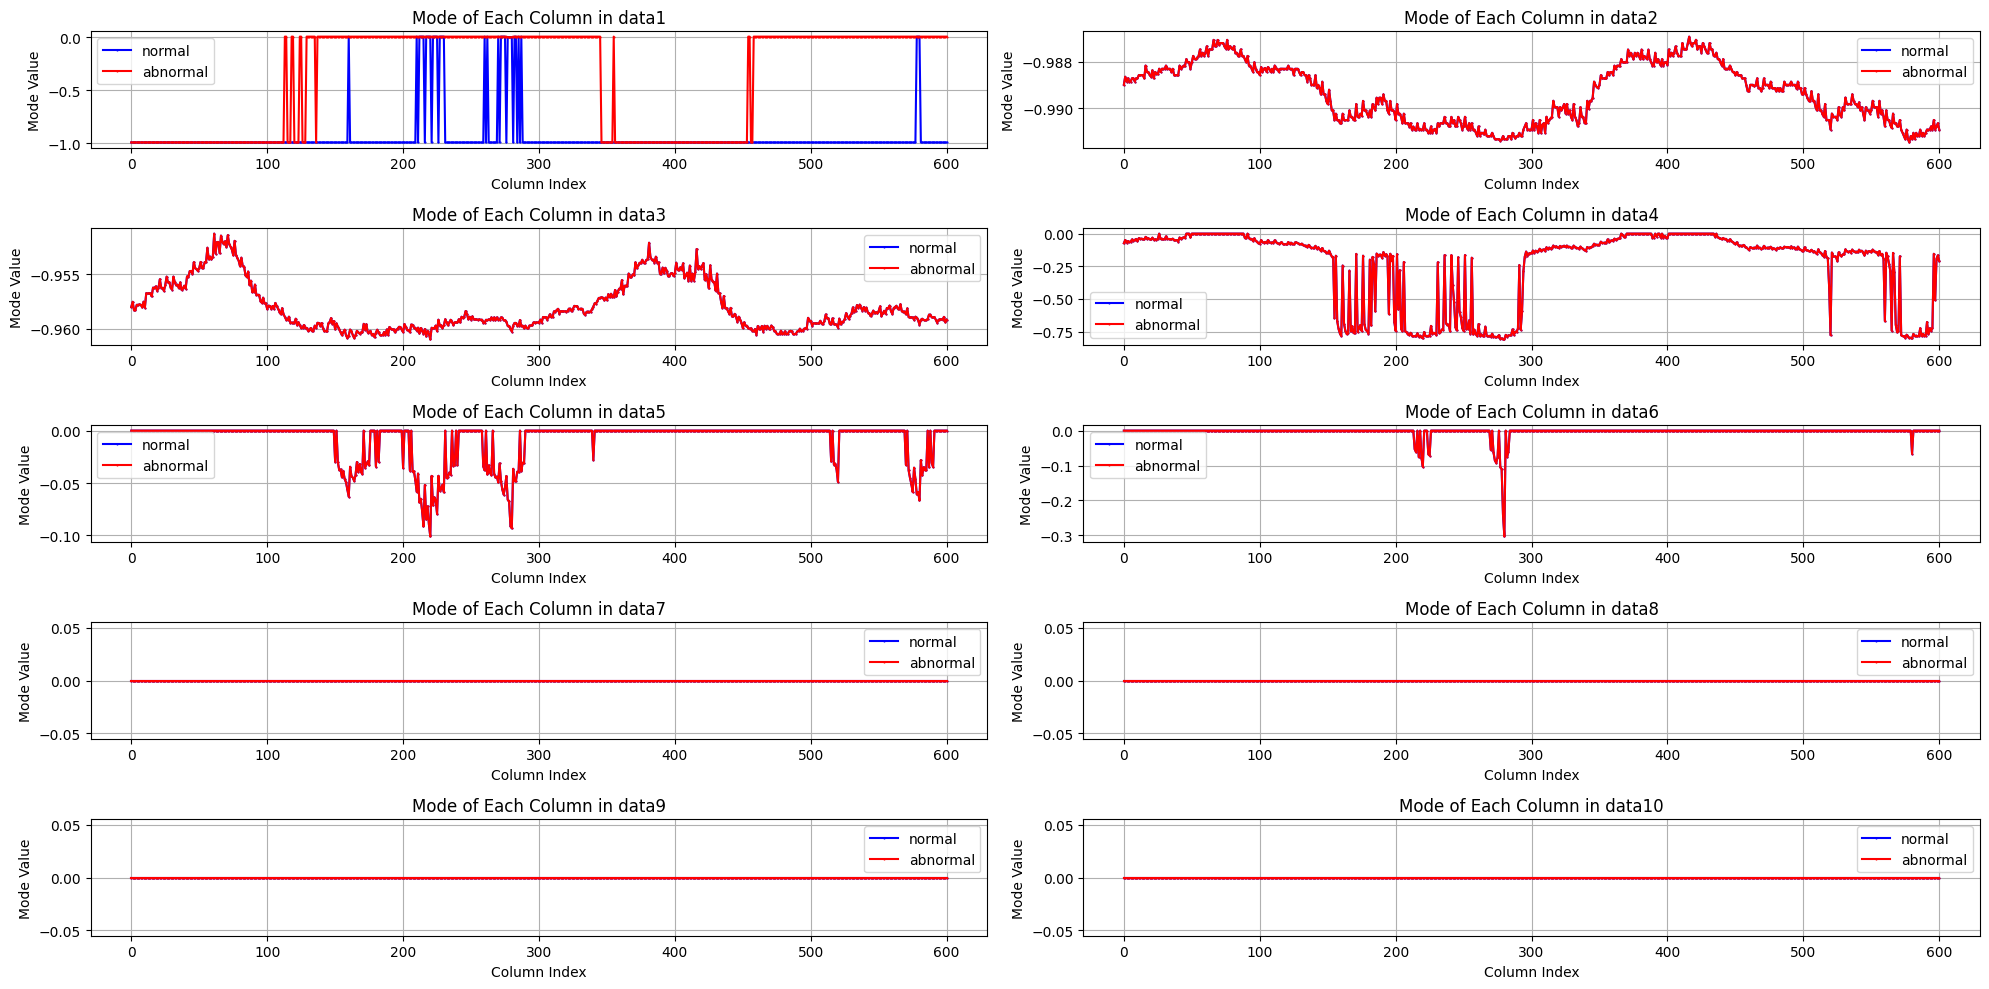

In [64]:
from scipy.stats import mode

plt.figure(figsize=(20, 10))

for i, df in enumerate(data_z_list):
    # 'event_time'과 'result' 열을 제외하고 각 열의 최빈값 계산
    df_result_0 = df[df['result'] == 0].drop(['result', 'event_time'], axis=1)
    df_result_1 = df[df['result'] == 1].drop(['result', 'event_time'], axis=1)

    column_modes_result_0 = df_result_0.mode().iloc[0]
    column_modes_result_1 = df_result_1.mode().iloc[0]

    # 시각화
    plt.subplot(5, 2, i + 1)
    plt.plot(column_modes_result_0, marker='o', linestyle='-', color='b', markersize=0.5, label='normal')
    plt.plot(column_modes_result_1, marker='o', linestyle='-', color='r', markersize=0.5, label='abnormal')
    plt.title(f'Mode of Each Column in data{columns_to_convert[i]}')
    plt.xlabel('Column Index')
    plt.ylabel('Mode Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [75]:
print(type(train_list[0]))

<class 'pandas.core.frame.DataFrame'>


In [76]:
train_list[0].head()

,0,1,2,3,4,5,6,7,8,9,...,592,593,594,595,596,597,598,599,600,result
4816,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,...,700.0,700.0,700.0,700.0,700.0,700.0,700.0,0.0,700.0,0
10775,0.0,0.0,0.0,0.0,0.0,696.0,696.0,696.0,696.0,696.0,...,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,0
4913,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
10815,0.0,0.0,0.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,...,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,0
7814,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,...,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,696.0,1


In [77]:
for i in range(len(train_list)):
    globals()[f"train_reg{i + 1}"] = train_list[i]
for i in range(len(test_list)):
    globals()[f"test_reg{i + 1}"] = test_list[i]

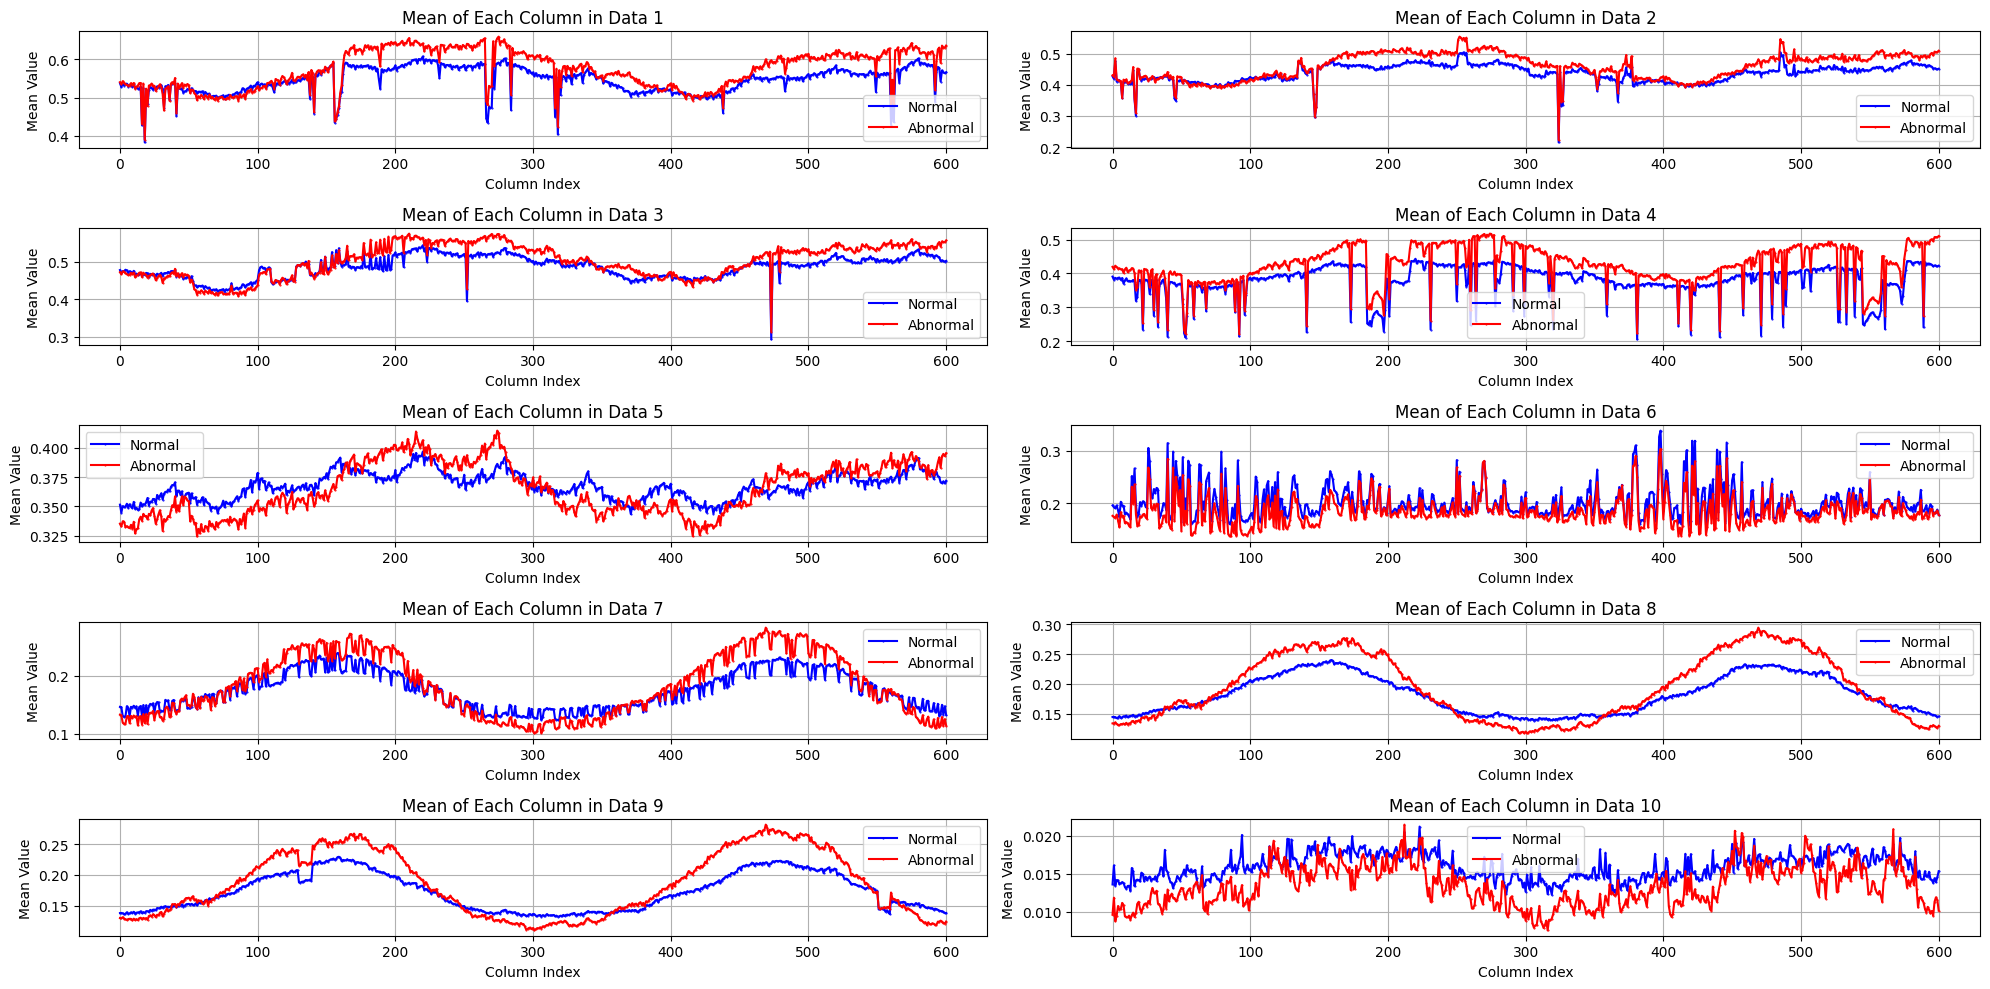

In [78]:
# Min-Max Scaler 적용
scaler = MinMaxScaler()
plt.figure(figsize=(20,10))

normal_mean_diff_list, abnormal_mean_diff_list = [], []

for i, df in enumerate(train_list):
    # 'event_time'과 'result' 열을 제외하고 데이터 스케일링
    df_scaled = pd.DataFrame(scaler.fit_transform(df.drop(['result'], axis=1)), columns=df.columns[:-1])

    # 'result' 열의 인덱스를 맞추기 위해 `reset_index()` 메서드를 사용
    df_result = df['result'].reset_index(drop=True)

    # 'result' 열을 기준으로 정상/비정상 데이터 분리
    df_normal = df_scaled[df_result == 0]
    df_abnormal = df_scaled[df_result == 1]

    # 각 데이터 그룹의 열 평균 계산
    df_normal_mean = df_normal.mean()
    df_abnormal_mean = df_abnormal.mean()

    #각 데이터 그룹의 최대-최소 계산
    normal_mean_diff = df_normal_mean.max(axis=0) - df_normal_mean.min(axis=0)
    abnormal_mean_diff = df_abnormal_mean.max(axis=0) - df_abnormal_mean.min(axis=0)

    normal_mean_diff_list.append(normal_mean_diff)
    abnormal_mean_diff_list.append(abnormal_mean_diff)
    
    # 시각화
    plt.subplot(5, 2, i+1)
    plt.plot(df_normal_mean, marker='o', linestyle='-', color='b', markersize=0.5, label='Normal')
    plt.plot(df_abnormal_mean, marker='o', linestyle='-', color='r', markersize=0.5, label='Abnormal')
    plt.title(f'Mean of Each Column in Data {i + 1}')
    plt.xlabel('Column Index')
    plt.ylabel('Mean Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()